# Prepare for colab

In [ ]:
!pip install catboost

# Kaggle Set Up

In [ ]:
# install kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Upload API Token

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


## Download and unzip dataset

In [ ]:
!kaggle datasets download -d huseyincot/amex-agg-data-pickle
!unzip /content/amex-agg-data-pickle.zip

 99% 2.75G/2.76G [00:13<00:00, 189MB/s]
100% 2.76G/2.76G [00:13<00:00, 223MB/s]
Archive:  /content/amex-agg-data-pickle.zip
  inflating: test_agg.pkl            
  inflating: train_agg.pkl           


In [ ]:
!kaggle competitions download -c amex-default-prediction -f sample_submission.csv
!unzip /content/sample_submission.csv.zip

 99% 32.0M/32.4M [00:00<00:00, 170MB/s] 
100% 32.4M/32.4M [00:00<00:00, 87.1MB/s]
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


# Settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import os
import gc; gc.enable()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
VER=1
SEED = 42
FOLDS = 5

cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]

# Training

In [ ]:
train = pd.read_pickle("../input/amex-agg-data-pickle/train_agg.pkl", compression="gzip")
train = train.reset_index(level=0)

test = pd.read_pickle("../input/amex-agg-data-pickle/test_agg.pkl", compression="gzip")
test = test.reset_index(level=0)

In [ ]:
cat_features_last = [f"{cf}_last" for cf in cat_features]

le_encoder = LabelEncoder()
for categorical_feature in cat_features_last:
    train[categorical_feature] = le_encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = le_encoder.transform(test[categorical_feature])

In [ ]:
# https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963
# Round last float features to 2 decimal place
float_cols = list(train.dtypes[(train.dtypes == 'float16') | (train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
float_cols = [col for col in float_cols if 'last' in col]

train[float_cols] = train[float_cols].round(2)
test[float_cols] = test[float_cols].round(2)

In [ ]:
train = train.set_index('customer_ID')
train = train.sort_index().reset_index()
FEATURES = train.drop(columns=['customer_ID', 'target']).columns

In [ ]:
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
# https://www.kaggle.com/code/rohanrao/amex-competition-metric-implementations
def amex_metric_np(target: np.ndarray, preds: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight * (1 / weight.sum())).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / n_pos
    
    lorentz = (target * (1 / n_pos)).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    g = gini / gini_max

    return 0.5 * (g + d)

In [ ]:
cat_params = {
    'iterations':26000,
    'random_state':SEED,
    'learning_rate':0.02,
    
    'depth': 4,
    'l2_leaf_reg':14.0,
    'one_hot_max_size':60,
    'task_type':"GPU",
    'border_count':128,
}

In [ ]:
importances = []
oof = []
gc.collect()

clf = CatBoostClassifier(**cat_params)
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(train, train.target)):
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with 100% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    X_train = train.loc[train_idx, FEATURES]
    X_valid = train.target.iloc[train_idx]
    y_train = train.loc[valid_idx, FEATURES]
    y_valid = train.target.iloc[valid_idx]
    
    # TRAIN MODEL FOLD K
    model = clf.fit(X_train,
                    X_valid,
                    cat_features=cat_features_last,
                    eval_set=[(y_train, y_valid)],
                    use_best_model=True,
                    early_stopping_rounds=300,
                    verbose_eval=500)
    model.save_model(f'CAT_v{VER}_fold{fold}.cbm')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.feature_importances_
    df = pd.DataFrame({'feature':FEATURES,f'importance_{fold}':dd})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict_proba(y_train)[:, 1]
    acc = amex_metric_np(y_valid.values, oof_preds)
    print('Amex Metric =',acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_preds'] = oof_preds
    oof.append(df)
    
    del X_train, y_train, dd, df
    del X_valid, y_valid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_np(oof.target.values, oof.oof_preds.values)
print(f"Overall Amex metric: {acc}")

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
0:	learn: 0.6696444	test: 0.6696301	best: 0.6696301 (0)	total: 29.9ms	remaining: 12m 57s
500:	learn: 0.2288998	test: 0.2303357	best: 0.2303357 (500)	total: 10.6s	remaining: 8m 59s
1000:	learn: 0.2225684	test: 0.2251068	best: 0.2251068 (1000)	total: 21.6s	remaining: 8m 59s
1500:	learn: 0.2194453	test: 0.2230824	best: 0.2230824 (1500)	total: 31.7s	remaining: 8m 36s
2000:	learn: 0.2173472	test: 0.2220242	best: 0.2220242 (2000)	total: 41.8s	remaining: 8m 21s
2500:	learn: 0.2157064	test: 0.2213480	best: 0.2213480 (2500)	total: 53.1s	remaining: 8m 18s
3000:	learn: 0.2142280	test: 0.2208516	best: 0.2208513 (2994)	total: 1m 3s	remaining: 8m 4s
3500:	learn: 0.2129335	test: 0.2204721	best: 0.2204721 (3500)	total: 1m 13s	remaining: 7m 49s
4000:	learn: 0.2117178	test: 0.2202155	best: 0.2202142 (3999)	total: 1m 23s	remaining: 7m 41s
4500:	learn: 0.2105954	test: 0

In [ ]:
# CLEAN RAM
del train
_ = gc.collect()

In [ ]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1, numeric_only=True)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'cat_feature_importance_v{VER}.csv',index=False)

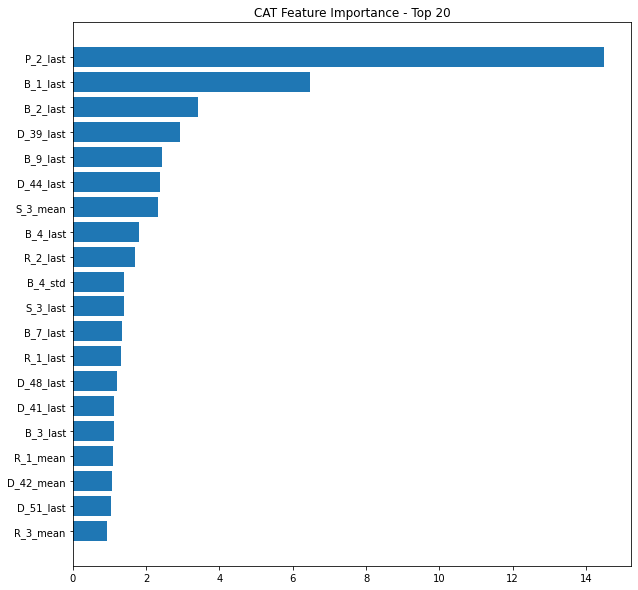

In [ ]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'CAT Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Test part

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [ ]:
# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4

customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[231155, 231155, 231155, 231156]


In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test_copy = test.iloc[skip_rows:skip_rows+rows[k]].copy()
    test_copy = test_copy.set_index('customer_ID')
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test_copy.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    if k==NUM_PARTS-1: test_copy = test_copy.loc[customers[skip_cust:]]
    else: test_copy = test_copy.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
        
    # INFER XGB MODELS ON TEST DATA
    model = CatBoostClassifier(**cat_params)
    model.load_model(f'CAT_v{VER}_fold0.cbm')
    preds = model.predict_proba(test_copy)[:, 1]
    for f in range(1,FOLDS):
        model.load_model(f'CAT_v{VER}_fold{f}.cbm')
        preds += model.predict_proba(test_copy)[:, 1]
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del test_copy, model
    _ = gc.collect()

del test
_ = gc.collect()

# Create a submission file

In [ ]:
# WRITE SUBMISSION FILE
# test_preds = np.concatenate(test_preds)
test = pd.DataFrame(index=customers,data={'prediction':test_preds})
sub = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].copy()
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_cat_v{VER}.csv',index=False)
print('Submission file shape is', sub.shape )
sub

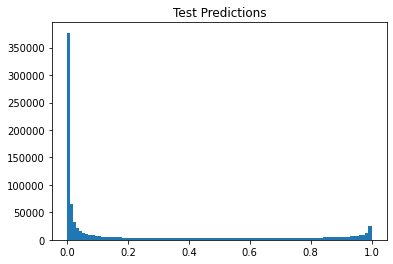

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

# Ensemble

## Preparing when Ensemble only

Run below codes.

In [ ]:
# # Load sample data
# sub = pd.read_csv('/content/sample_submission.csv')

## Do ensemble

In [ ]:
!kaggle datasets download -d ryuina/amexdefaultsubmissions
!unzip /content/amexdefaultsubmissions.zip

 99% 277M/280M [00:02<00:00, 80.4MB/s]
100% 280M/280M [00:02<00:00, 113MB/s] 
Archive:  /content/amexdefaultsubmissions.zip
  inflating: amex-default-submissions/submission_CosSquareFormer_0788.csv  
  inflating: amex-default-submissions/submission_cat_v20.csv  
  inflating: amex-default-submissions/submission_cat_v26.csv  
  inflating: amex-default-submissions/submission_xgb_v10.csv  
  inflating: amex-default-submissions/submission_xgb_v16.csv  
  inflating: amex-default-submissions/submission_xgb_v7.csv  
  inflating: amex-default-submissions/test_lgbm_baseline_5fold_seed42.csv  


In [ ]:
# https://www.kaggle.com/code/beezus666/ensemble-weighted-average
#crude formula for model weighting.
# Using this formaula the best model's weight = 1, the worst model's weight ~0.05
def model_weight(model_loss, worst_loss, best_loss):
    return 1- ((best_loss - model_loss)/(best_loss-(worst_loss - 0.01)))

def read_weighted_preds(sub_dict: dict, worst_score:float, best_score: float) -> list:
    preds = []
    weights = []
    for path, loss in sub_dict.items():
        weight = model_weight(loss, worst_score, best_score)
        
        df = pd.read_csv(path)
        df = df.set_index('customer_ID').sort_index().reset_index() # sort
        df['prediction'] = df['prediction']*weight
        
        preds.append(df['prediction'])
        weights.append(weight)
    
    return preds, weights

In [ ]:
best = 0.7963
worst = 0.789
sub_dict = {
    '../input/amex-default-prediction-with-cat/submission_cat_v1.csv': 0.794,
    '../input/amexdefaultsubmissions/amex-default-submissions/submission_TF_GRU0789.csv': 0.789,
#     '../input/amexdefaultsubmissions/amex-default-submissions/submission_xgb_v7.csv': 0.794,
    '../input/amexdefaultsubmissions/amex-default-submissions/test_lgbm_baseline_5fold_seed42.csv': 0.7963,
#     '../input/amexdefaultsubmissions/amex-default-submissions/submission_cat_0.7923765971248049.csv': 0.7924,
    '../input/amexdefaultsubmissions/amex-default-submissions/submission_downsampling0791.csv': 0.791,
    '../input/amexdefaultsubmissions/amex-default-submissions/submission_tabnet0791.csv': 0.791,
    '../input/amexdefaultsubmissions/amex-default-submissions/lightautoml_tabularautoml0795.csv': 0.795,
    '../input/amexdefaultsubmissions/amex-default-submissions/submission_xgb_nvt_0._794csv.csv': 0.794
}

preds, weights = read_weighted_preds(sub_dict, worst, best)

In [ ]:
blend_weight = (np.sum(np.column_stack(preds), axis=1) / sum(weights))
blend_mean = (np.mean(np.column_stack(preds), axis=1))

print(f"weight: {blend_weight}")
print(f"mean: {blend_mean}")

weight: [0.02398101 0.00124885 0.04104518 ... 0.48290936 0.29330231 0.05692538]
mean: [0.01926798 0.00100341 0.0329785  ... 0.38800232 0.23565909 0.04573773]


In [ ]:
sub = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]

In [ ]:
blend_ss = sub.copy()
blend_ss['prediction'] = (np.sum(np.column_stack(preds), axis=1) / sum(weights))
blend_ss.to_csv('submission_blend.csv', index=False)
blend_ss

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.023981
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001249
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.041045
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.252061
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.755853
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.014509
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.695118
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.482909
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.293302


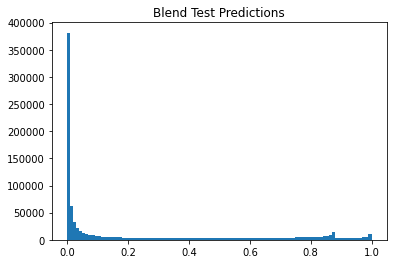

In [ ]:
# PLOT PREDICTIONS
plt.hist(blend_ss.prediction, bins=100)
plt.title('Blend Test Predictions')
plt.show()

# Submit to Kaggle from Colab

In [ ]:
# Submit
# !kaggle competitions submit -c amex-default-prediction -f submission_cat_v1.csv -m "From colab"
!kaggle competitions submit -c amex-default-prediction -f submission_blend.csv -m "From colab"

100% 75.3M/75.3M [00:03<00:00, 26.2MB/s]
Successfully submitted to American Express - Default Prediction

In [ ]:
# Run after few seconds
!kaggle competitions submissions amex-default-prediction

fileName                          date                 description                                             status    publicScore  privateScore  
--------------------------------  -------------------  ------------------------------------------------------  --------  -----------  ------------  
submission_blend.csv              2022-06-21 15:30:49  From colab                                              complete  0.797                      
Amex Default Prediction with Cat  2022-06-21 03:33:07  Notebook Amex Default Prediction with Cat | Version 30  complete  0.795                      
Amex Default Prediction with Cat  2022-06-21 03:24:02  Notebook Amex Default Prediction with Cat | Version 29  complete  0.795                      
Amex Default Prediction with Cat  2022-06-21 03:03:40  Notebook Amex Default Prediction with Cat | Version 28  complete  0.795                      
Amex Default Prediction with Cat  2022-06-21 02:51:50  Notebook Amex Default Prediction with Cat | Version